In [ ]:
## evaluation training run outputs ##

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import sys
import os

In [2]:
sys.path.insert(0, "/home/kylabazlen/")
plotting = importlib.import_module("2026_nvhackathon.validation.plotting")
configure_style = plotting.configure_style
filter_df_by_location = plotting.filter_df_by_location
filter_df_by_time = plotting.filter_df_by_time
COLORS = plotting.COLORS
MARKERS = plotting.MARKERS
plot_timeseries = plotting.plot_timeseries
plot_station_gof_map = plotting.plot_station_gof_map
density_scatter = plotting.density_scatter

evaluation = importlib.import_module("2026_nvhackathon.cowy_point_correction.cowy.evaluation.metrics")
evaluate_bins = evaluation.evaluate_bins
format_results_table = evaluation.format_results_table

In [3]:
#read in predictions and observations and orgiional forecast for the testing split
base_path_run = "/project/cowy-nvhackathon/cowy-wildfire/data/prepare_data_out_small/lightning_logs_v1/ifs_point_correction_v1/version_24/best_ckpt_results"

ml_predictions = np.load(os.path.join(base_path_run, "pred_test.npy"))
observations = np.load(os.path.join(base_path_run, "obs_test.npy"))
test_obs_lookup = pd.read_csv(os.path.join(base_path_run, "test_obs_lookup.csv"))

ifs_forecast = np.load(os.path.join(base_path_run, "inputs_test.npy"))
ifs_forecast_ws = ifs_forecast[:, 30:31]

In [4]:
#read in obs look up
test_obs_lookup = pd.read_csv(os.path.join(base_path_run, "test_obs_lookup.csv"))

In [ ]:
import matplotlib.pyplot as plt

plt.hist(ifs_forecast_ws, bins=29)

plt.show()

In [5]:
test_obs_lookup['prediction'] = ml_predictions.flatten()
test_obs_lookup['observation'] = observations.flatten()
test_obs_lookup['error_model'] = test_obs_lookup['prediction'] - test_obs_lookup['observation']

test_obs_lookup['ifs_forecast'] = ifs_forecast_ws.flatten()
test_obs_lookup['error_ifs'] = test_obs_lookup['ifs_forecast'] - test_obs_lookup['observation']
test_obs_lookup['error_diff'] = test_obs_lookup['error_model'] - test_obs_lookup['error_ifs']

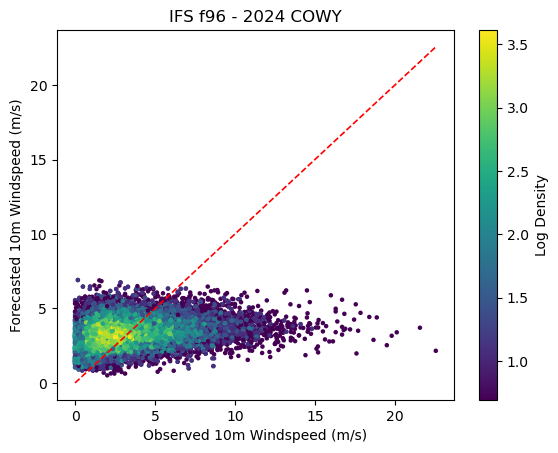

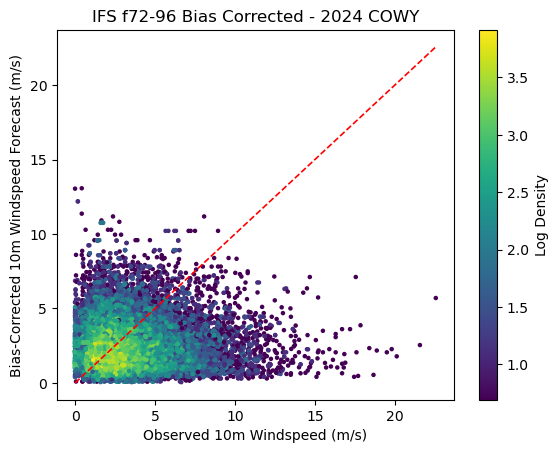

In [6]:
# Scatter plot for ML predictions
x = test_obs_lookup["observation"].values
y = test_obs_lookup["prediction"].values

ax = density_scatter(x=x, y=y)
ax.set_xlabel("Observed 10m Windspeed (m/s)")
ax.set_ylabel("Forecasted 10m Windspeed (m/s)")
ax.set_title("IFS f96 - 2024 COWY")

# Scatter plot for ML predictions
x_bl = test_obs_lookup["observation"].values
y_bl = test_obs_lookup["ifs_forecast"].values

ax = density_scatter(x=x_bl, y=y_bl)
ax.set_xlabel("Observed 10m Windspeed (m/s)")
ax.set_ylabel("Bias-Corrected 10m Windspeed Forecast (m/s)")
ax.set_title("IFS f72-96 Bias Corrected - 2024 COWY")
plt.show()

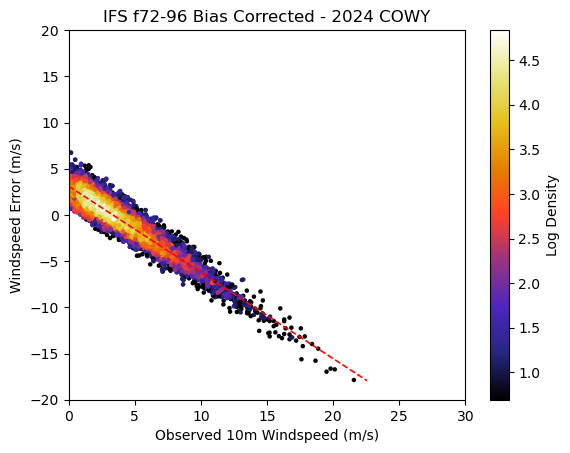

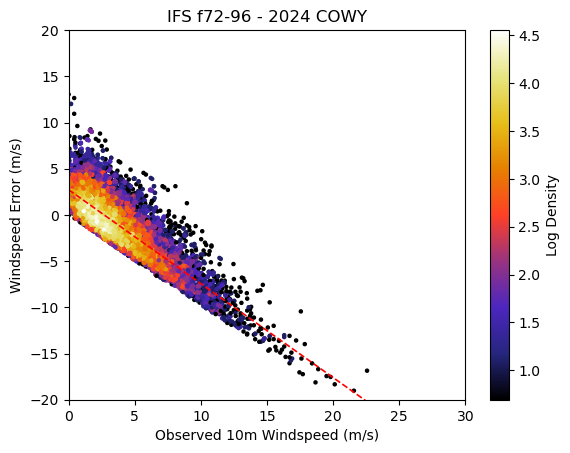

In [7]:
y = test_obs_lookup['error_model'].values
x = test_obs_lookup["observation"].values


ax = density_scatter(x=x, y=y, cmap="CMRmap", one_to_one_line = False, trend_line=True)
ax.set_xlabel("Observed 10m Windspeed (m/s)")
ax.set_ylabel("Windspeed Error (m/s)")
ax.set_title("IFS f72-96 Bias Corrected - 2024 COWY")

ax.set_xlim(0, 30)  # X-axis from 0 to 30 m/s
ax.set_ylim(-20, 20)  # Y-axis (error) from -10 to +10 m/s
plt.show()

y_bl = test_obs_lookup['error_ifs'].values
x_bl = test_obs_lookup["observation"].values


ax = density_scatter(x=x_bl, y=y_bl, cmap="CMRmap", one_to_one_line = False, trend_line=True)
ax.set_xlabel("Observed 10m Windspeed (m/s)")
ax.set_ylabel("Windspeed Error (m/s)")
ax.set_title("IFS f72-96 - 2024 COWY")

ax.set_xlim(0, 30)  # X-axis from 0 to 30 m/s
ax.set_ylim(-20, 20)  # Y-axis (error) from -10 to +10 m/s
plt.show()

## plot time series

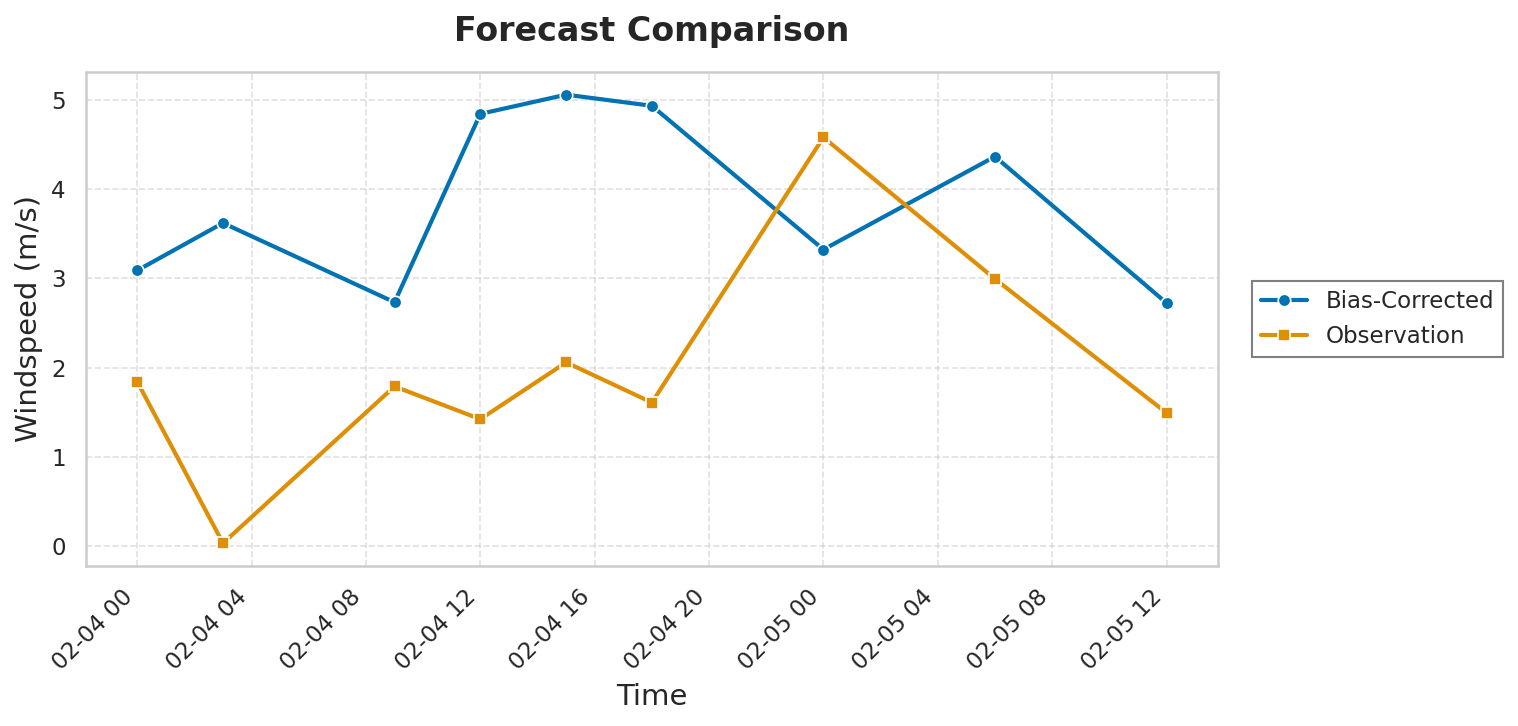

In [8]:
configure_style()

fig, ax = plot_timeseries(
    test_obs_lookup,
    lines=[
        {"col": "prediction", "label": "Bias-Corrected"},
        {"col": "observation", "label": "Observation"},
        # {"col": "ifs_forecast", "label": "Raw IFS"},
    ],
    latitude=41.88616,
    longitude=-106.16315,
    start="2024-02-01",
    end="2024-06-15",
    ylabel="Windspeed (m/s)",
    title="Forecast Comparison",
)

In [ ]:
## Map

In [9]:
import geopandas as gpd
from shapely.geometry import box
dem = xr.open_dataset('/gscratch/kylabazlen/terrain_data/terrain_990m/conus_elev_reprojected_wgs84_cowy_990m.nc')
states = gpd.read_file('/gscratch/kylabazlen/terrain_data/states/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

min_lon = -111.0  # or whatever value you want

dem = dem.sel(
    longitude=slice(min_lon, None)
)

# Get the extent of your DEM
min_lon = dem['longitude'].min()
max_lon = dem['longitude'].max()
min_lat = dem['latitude'].min()
max_lat = dem['latitude'].max()

# Create a bounding box from the DEM extent
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=states.crs)

# Clip states to the DEM extent
states_clipped = gpd.clip(states, bbox_gdf)

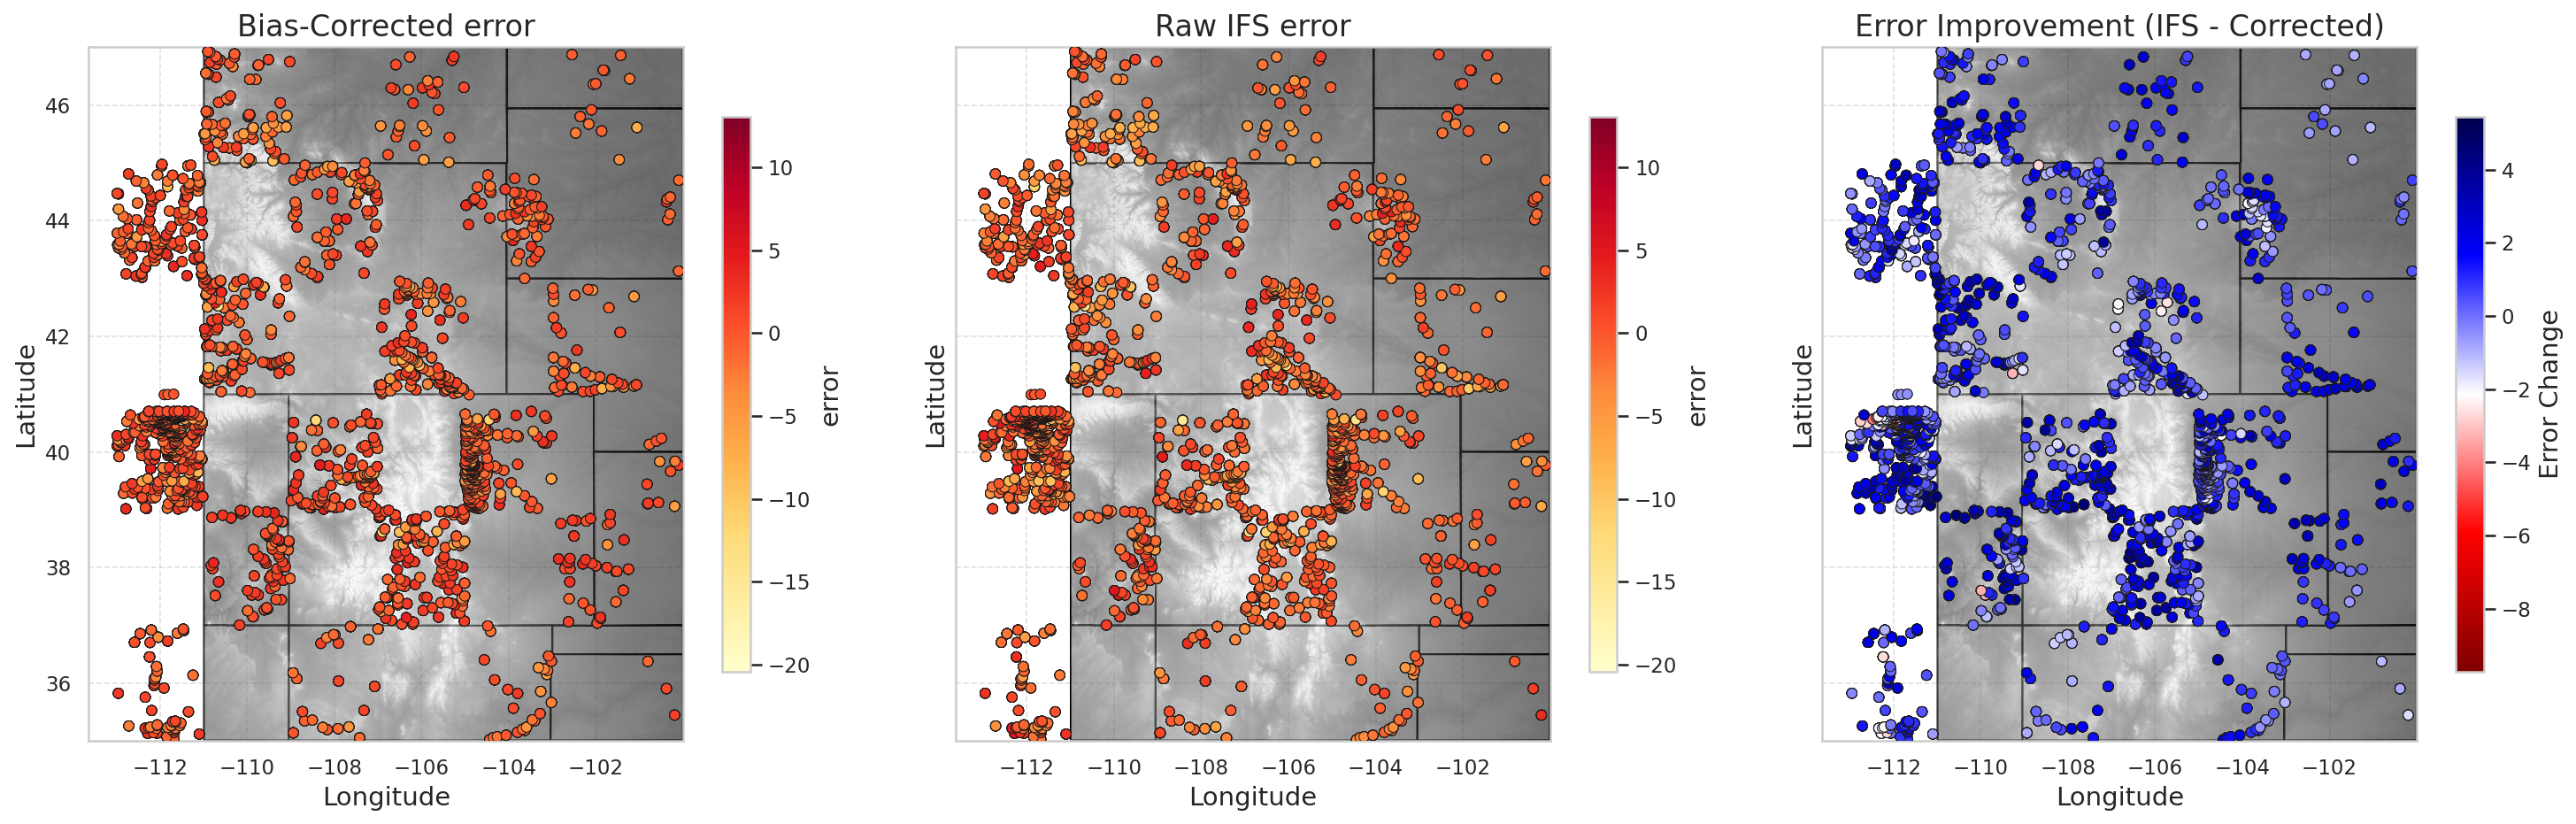

In [10]:
vmin = min(
    test_obs_lookup['error_ifs'].min(),
    test_obs_lookup['error_model'].min()
)
vmax = max(
    test_obs_lookup['error_ifs'].max(),
    test_obs_lookup['error_model'].max()
)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

plot_station_gof_map(
    test_obs_lookup,
    rmse_col='error_ifs',
    title='Raw IFS error',
    cbar_label='error',
    ax=axes[1],
    state_borders=states_clipped,
    dem=dem,
    vmin=vmin,
    vmax=vmax,
)

plot_station_gof_map(
    test_obs_lookup,
    rmse_col='error_model',
    title='Bias-Corrected error',
    cbar_label='error',
    ax=axes[0],
    state_borders=states_clipped,
    dem=dem,
    vmin=vmin,
    vmax=vmax,
)

plot_station_gof_map(
    test_obs_lookup,
    rmse_col='error_diff',
    cmap='seismic_r',
    title='Error Improvement (IFS - Corrected)',
    cbar_label='Error Change',
    ax=axes[2],
    state_borders=states_clipped,
    dem=dem
)

plt.tight_layout()
plt.show()